In [1]:
plt = plotter()

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import jax
import jax.lax as lax
import jax.numpy as np

In [4]:
# HOM-HOM-HOM-HOM HOMPACK90 STYLE
def row_map(dets, tv):
    i, qrow = tv
    n, = qrow.shape
    d = -np.dot(qrow, dets)
    isel = np.arange(n) == i
    dets1 = np.where(isel, d, dets)
    return dets1, d

def row_dets(mat):
    n, m = mat.shape
    qr = np.linalg.qr(mat, 'r')
    msel = np.arange(m) == m - 1
    dets0 = np.where(msel, 1.0, 0.0)
    ivec = np.arange(m-2, -1, -1)
    dets, _ = lax.scan(row_map, dets0, (ivec, qr))
    qdiag = np.diag(qr)
    dets1 = np.sign(np.prod(qdiag))*(dets/qdiag) # just for the sign
    # dets1 = np.prod(qdiag)*dets # to get the scale exactly
    return dets1

In [5]:
f0 = lambda x, b: x**2 + 2*b*x + 1
f = lambda x, b: f0(x, b) + 0.03j

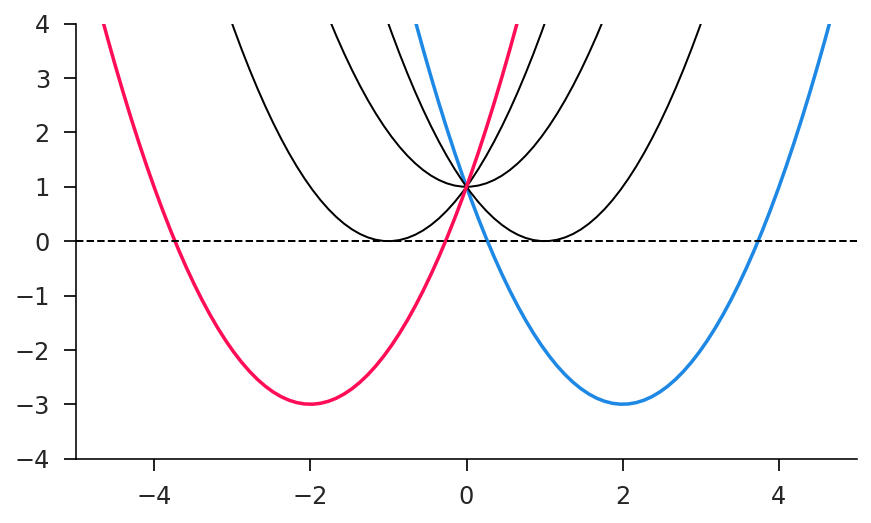

In [6]:
xgrid = np.linspace(-5, 5, 100)
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(xgrid, f0(xgrid, -2))
ax.plot(xgrid, f0(xgrid, -1), color='k', linewidth=1)
ax.plot(xgrid, f0(xgrid, 0), color='k', linewidth=1)
ax.plot(xgrid, f0(xgrid, 1), color='k', linewidth=1)
ax.plot(xgrid, f0(xgrid, 2))
ax.plot(xgrid, np.zeros_like(xgrid), color='k', linestyle='--', linewidth=1)
ax.set_ylim(-4, 4); ax.set_xlim(-5, 5);

In [7]:
fx = jax.jacobian(f, argnums=0, holomorphic=True)
fb = jax.jacobian(f, argnums=1, holomorphic=True)

In [8]:
K = 550
delt = 0.01
b0 = np.array([-2.0 + 0.0j])
b1 = np.array([2.0 + 0.0j])
db = b1 - b0 # linear path
x0a = -b0 - np.sqrt(b0**2-1)
x0b = -b0 + np.sqrt(b0**2-1)

In [9]:
def step_path(st, tv):
    x0, b0, t0 = st

    # compute values
    fx_val = fx(x0, b0)
    fb_val = fb(x0, b0)

    # prediction step
    tdir_val = np.dot(fb_val, db)
    jac_val = np.hstack([fx_val, tdir_val[:, None]])
    step_pred = row_dets(jac_val)

    # normalize and direct step
    step_pred = step_pred*(delt/np.mean(np.abs(step_pred)))
    step_pred = step_pred*np.sign(step_pred[-1])
    dxp, dtp = step_pred[:-1], step_pred[-1]

    # apply prediction
    x1 = x0 + dxp
    b1 = b0 + dtp*db
    t1 = t0 + dtp

    # compute values
    f_val = f(x1, b1)
    fx_val = fx(x1, b1)
    fb_val = fb(x1, b1)

    # correction step
    proj_dir = np.hstack([np.zeros_like(x1), 1.0]) # step_pred
    tdir_val = np.dot(fb_val, db)
    jac_val = np.hstack([fx_val, tdir_val[:, None]])
    proj_val = np.vstack([jac_val, proj_dir])
    step_corr = -np.linalg.solve(proj_val, np.hstack([f_val, 0.0]))
    dxc, dtc = step_corr[:-1], step_corr[-1]

    # apply correction
    x2 = x1 + dxc
    b2 = b1 + dtc*db
    t2 = t1 + dtc

    # return state/hist
    st1 = x2, b2, t2
    hst = x2, b2, t2
    return st1, hst

In [10]:
_, (xp1, bp1, tp1) = lax.scan(step_path, (x0a, b0, 0.0), np.arange(K))
_, (xp2, bp2, tp2) = lax.scan(step_path, (x0b, b0, 0.0), np.arange(K))

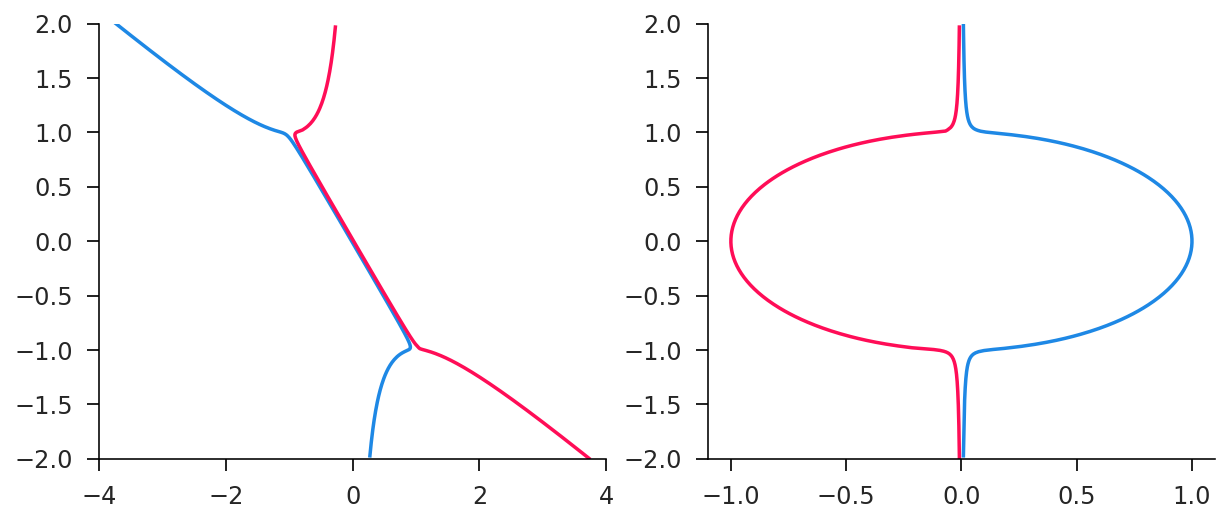

In [11]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.plot(xp1.real, bp1.real);
ax0.plot(xp2.real, bp2.real);
ax1.plot(xp1.imag, bp1.real);
ax1.plot(xp2.imag, bp2.real);
ax0.set_ylim(-2, 2); ax1.set_ylim(-2, 2);
ax0.set_xlim(-4, 4); ax1.set_xlim(-1.1, 1.1);